In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from scipy.stats import norm

In [16]:
plt.rcParams['figure.figsize'] = (10,5)

In [17]:
data = pd.read_csv("../spectra/eso/uucnc_harps.csv")
data.flux_err = 1. / np.sqrt(data.flux)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


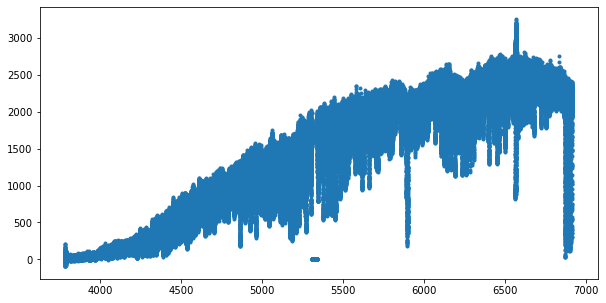

In [18]:
plt.plot(data.wave, data.flux, '.')

In [19]:
wmin, wmax = 5200, 5280

In [20]:
widx = (wmin<data.wave) & (data.wave<wmax)

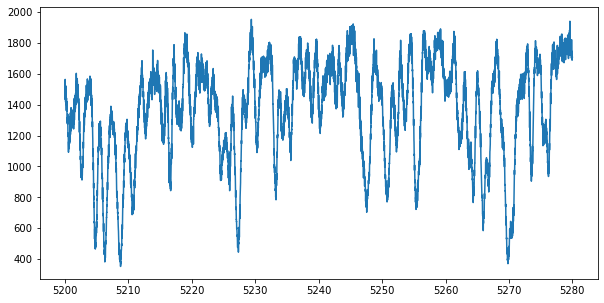

In [21]:
plt.plot(data.wave[widx], data.flux[widx])

In [22]:
h1, h2 = 10, 10

In [48]:
def nonlin(x):
    return jnp.maximum(x, 0.)

In [108]:
def model(X, Y, D_H):

    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample(
        "w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)))
    )  # D_X D_H
    z1 = nonlin(jnp.matmul(X, w1))  # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample(
        "w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H)))
    )  # D_H D_H
    z2 = nonlin(jnp.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = numpyro.sample(
        "w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)))
    )  # D_H D_Y
    z3 = jnp.matmul(z2, w3)  # N D_Y  <= output of the neural network

    # we put a prior on the observation noise
    #prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 0.1 #1.0 / jnp.sqrt(prec_obs)

    # observe data
    numpyro.sample("Y", dist.Normal(z3, sigma_obs), obs=Y)

In [109]:
x_data = jnp.array(data.wave[widx])[:,None]
y_data = jnp.array(data.flux[widx])[:,None]

In [110]:
def normalize(x):
    return (x - jnp.mean(x)) / jnp.std(x)

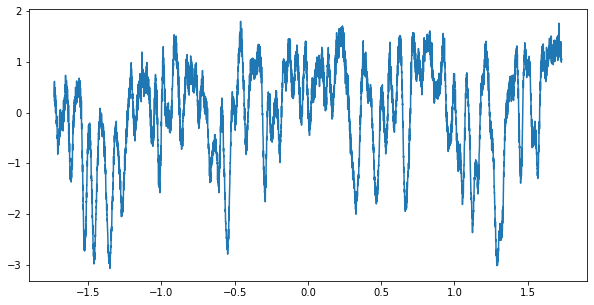

In [111]:
plt.plot(normalize(x_data).T[0], normalize(y_data).T[0])

In [112]:
kernel = numpyro.infer.NUTS(model)

In [113]:
n_sample = 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_sample, num_samples=n_sample)

In [114]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, normalize(x_data), normalize(y_data), 10)

sample: 100%|███████████████████████████████████████| 1000/1000 [05:59<00:00,  2.78it/s, 1023 steps of size 4.50e-04. acc. prob=0.90]


In [115]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   w1[0,0]      0.36      0.72      0.30     -0.71      1.56      4.65      1.75
   w1[0,1]      0.43      0.59      0.40     -0.51      1.22      8.08      1.04
   w1[0,2]      0.10      0.41     -0.01     -0.39      0.83      6.95      1.04
   w1[0,3]     -0.19      0.83     -0.10     -1.83      0.90      4.20      1.61
   w1[0,4]     -0.07      0.78      0.10     -1.40      0.93      6.71      1.07
   w1[0,5]      0.49      0.33      0.45     -0.02      1.01      3.01      2.27
   w1[0,6]      0.13      0.81      0.16     -0.91      1.37      3.26      2.23
   w1[0,7]     -0.62      0.54     -0.64     -1.50      0.25      4.67      1.52
   w1[0,8]     -0.35      0.49     -0.33     -1.26      0.22      3.02      2.74
   w1[0,9]     -0.14      0.40     -0.02     -0.83      0.37      4.37      1.21
   w2[0,0]      0.08      1.09     -0.03     -1.62      2.07      8.08      1.01
   w2[0,1]     -0.30      1

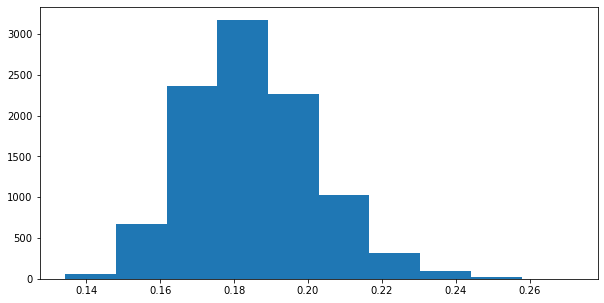

In [116]:
plt.hist(1/np.sqrt(np.array(dist.Gamma(30, 1).sample(random.PRNGKey(0), sample_shape=(10000,)))));

In [117]:
predictive = Predictive(model, mcmc.get_samples())

In [118]:
x_new = jnp.linspace(-2, 2, 1000)[:,None]

In [119]:
y_pred = predictive(random.PRNGKey(0), X=x_new, Y=None, D_H=10)

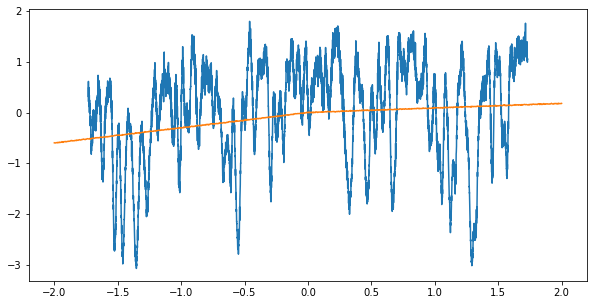

In [120]:
plt.plot(normalize(x_data), normalize(y_data));
plt.plot(x_new, y_pred['Y'].mean(axis=0)[:,0]);